# Running AttAttribute in previous version

In [1]:
# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    translate_comp_graph_deprecated,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)

from torch_geometric.utils import get_num_hops, get_num_hops

from typing import Tuple

import torch
from models import GAT_L2_intervention
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)
from torch_geometric.utils import get_num_hops
from typing import Tuple
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


def get_edge_scores(
    target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict, att
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt



# Let's refactor tha code below as a function
def experiment_on_target_node(
    target_idx: int, data, model, self_loops=True, verbose=False
):
    # 1. Get the number of hops according to the model
    num_hops = get_num_hops(model)
    # 2. Get all edges within the target node's k-hop neighborhood
    edge_lists = return_edges_in_k_hop(
        data=data, target_idx=target_idx, hop=2, self_loops=self_loops
    )
    if verbose:
        print(f"Number of edges in the k-hop neighborhood: {len(edge_lists)}")

    # 3. For all edges in the k-hop neighborhood, we get the attribution scores
    # according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
    # First, prepare ingredients for analysis

    num_layers = get_num_hops(model)
    att_dict_raw = get_attention_raw_dict(model, data)
    att_dict = process_attention_dict(att_dict_raw)
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph_deprecated(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )

    # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
    # Output without any masking
    with torch.no_grad():
        output = model(
            x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
        )
        att = model.att
        pred = output.argmax(dim=1)[target_idx].item()  # Single integer
        pred_prob = output[target_idx].softmax(dim=0)[pred].item()  # Single float
        prob_vector = output[target_idx].softmax(dim=0)  # 1D vector of floats
        entropy = -(prob_vector * prob_vector.log()).sum().item()  # Single float
    # Get results for all edges in the k-hop neighborhood
    attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
    for current_edge in edge_lists:
        attattribute, attattribute_sim, avgatt = get_edge_scores(
            target_edge=tuple(current_edge),
            comp_graph=comp_graph,
            comp_graph_new=comp_graph_new,
            layer_att_dict=layer_att_dict,
            att=att,
        )
        attattribute_list.append(attattribute)
        attattribute_sim_list.append(attattribute_sim)
        avgatt_list.append(avgatt)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), ATTATTRIBUTE: {attattribute:.4f}, ATTATTRIBUTE_sim: {attattribute_sim:.4f}, AVGATT: {avgatt:.4f}"
            )

    # 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
    # by masking the edge.
    # Output with masking
    pred_list_masked, pred_prob_list_masked, entropy_list_masked = [], [], []
    for current_edge in edge_lists:
        with torch.no_grad():
            output_masked = model(
                x=data.x,
                edge_index=data.edge_index,
                return_att=True,
                mask_edge=current_edge,
            )
            att_masked = model.att
            pred_masked = output_masked.argmax(dim=1)[target_idx].item()
            pred_prob_masked = (
                output_masked[target_idx].softmax(dim=0)[pred_masked].item()
            )
            prob_vector_masked = output_masked[target_idx].softmax(dim=0)
            entropy_masked = (
                -(prob_vector_masked * prob_vector_masked.log()).sum().item()
            )
        pred_list_masked.append(pred_masked)
        pred_prob_list_masked.append(pred_prob_masked)
        entropy_list_masked.append(entropy_masked)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), prediction: {pred:1d} → {pred_masked:1d}, Δpred_prob: {pred_prob - pred_prob_masked:.4f}, Δentropy: {entropy - entropy_masked:.4f}"
            )
    # For pred_list_masked, change into a list of bools indicating whether the prediction has changed
    # Compare pred_list_masked with
    pred_list_masked_bool = [pred != curr_pred for curr_pred in pred_list_masked]
    # For pred_prob_list_masked, change into a list of floats indicating the change in prediction probability
    pred_prob_list_masked_float = [
        pred_prob - curr_pred_prob for curr_pred_prob in pred_prob_list_masked
    ]
    # For entropy_list_masked, change into a list of floats indicating the change in entropy
    entropy_list_masked_float = [
        curr_entropy - entropy for curr_entropy in entropy_list_masked
    ]

    return (
        attattribute_list,
        attattribute_sim_list,
        avgatt_list,
        pred_list_masked_bool,
        pred_prob_list_masked_float,
        entropy_list_masked_float,
    )

In [2]:
import torch

dataset_name = 'BA-Shapes'
model_name = 'GAT_BAShapes_3L1H'
dataset_folder = 'Datasets'
model_folder = 'Models'

# Load the data
data = torch.load(f'/workspace/{dataset_folder}/{dataset_name}.pt',map_location ='cpu')
# Load the model
model = torch.load(f'/workspace/{model_folder}/{model_name}.pt',map_location ='cpu')
model.eval()
# Get the attention weights
with torch.no_grad():
    out = model(data.x, data.edge_index, return_att=True)
    att = model.att 

In [3]:
# # This works
# target_node = 0

# target_node_results = experiment_on_target_node(
#     target_idx=target_node,
#     data=data,
#     model=model,
#     self_loops=True,
# )

In [4]:
# target_idx = 0
# data = data
# model = model
# self_loops = True
# verbose = False

# import time # for profiling

# time_flag = time.time()
# # 1. Get the number of hops according to the model
# num_hops = get_num_hops(model)
# # 2. Get all edges within the target node's k-hop neighborhood
# edge_lists = return_edges_in_k_hop(
#     data=data, target_idx=target_idx, hop=2, self_loops=self_loops
# )
# if verbose:
#     print(f"Number of edges in the k-hop neighborhood: {len(edge_lists)}")
# print(f"Time elapsed (stage 1): {time.time() - time_flag:.2f} seconds")
# time_flag = time.time()

# # 3. For all edges in the k-hop neighborhood, we get the attribution scores
# # according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
# # First, prepare ingredients for analysis

# num_layers = get_num_hops(model)
# att_dict_raw = get_attention_raw_dict(model, data)
# att_dict = process_attention_dict(att_dict_raw)
# print(f"Time elapsed (stage 2): {time.time() - time_flag:.2f} seconds")
# time_flag = time.time()
# comp_graph = get_computation_graph(
#     edge_index=data.edge_index, k=num_layers, target_idx=target_idx
# )
# (
#     nodes_per_level_original,
#     num_nodes_per_level,
#     true_node_label,
# ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
# nodes_per_level_new = reindex_nodes_per_level(
#     nodes_per_level_original, num_nodes_per_level
# )
# comp_graph_new = translate_comp_graph_deprecated(
#     comp_graph=comp_graph,
#     nodes_per_level_new=nodes_per_level_new,
#     nodes_per_level_original=nodes_per_level_original,
# )
# layer_att_dict = get_att_dict_per_layer(
#     comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
# )
# print(f"Time elapsed (stage 3): {time.time() - time_flag:.2f} seconds")
# time_flag = time.time()

# # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
# # Output without any masking
# with torch.no_grad():
#     output = model(
#         x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
#     )
#     att = model.att
#     pred = output.argmax(dim=1)[target_idx].item()  # Single integer
#     pred_prob = output[target_idx].softmax(dim=0)[pred].item()  # Single float
#     prob_vector = output[target_idx].softmax(dim=0)  # 1D vector of floats
#     entropy = -(prob_vector * prob_vector.log()).sum().item()  # Single float

# print(f"Time elapsed (stage 4): {time.time() - time_flag:.2f} seconds")
# time_flag = time.time()

# # Get results for all edges in the k-hop neighborhood
# attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
# for current_edge in edge_lists:
#     attattribute, attattribute_sim, avgatt = get_edge_scores(
#         target_edge=tuple(current_edge),
#         comp_graph=comp_graph,
#         comp_graph_new=comp_graph_new,
#         layer_att_dict=layer_att_dict,
#         att=att,
#     )
#     attattribute_list.append(attattribute)
#     attattribute_sim_list.append(attattribute_sim)
#     avgatt_list.append(avgatt)
#     if verbose:
#         print(
#             f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), ATTATTRIBUTE: {attattribute:.4f}, ATTATTRIBUTE_sim: {attattribute_sim:.4f}, AVGATT: {avgatt:.4f}"
#         )
# time_for_loop = time.time() - time_flag
# print(f"Time elapsed (stage 5): {time_for_loop:.2f} seconds")
# print(f"Time elapsed per loop: {time_for_loop/len(edge_lists):.2f} seconds")
# # 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
# # by masking the edge.
# # Output with masking
# # pred_list_masked, pred_prob_list_masked, entropy_list_masked = [], [], []
# # for current_edge in edge_lists:
# #     with torch.no_grad():
# #         output_masked = model(
# #             x=data.x,
# #             edge_index=data.edge_index,
# #             return_att=True,
# #             mask_edge=current_edge,
# #         )
# #         att_masked = model.att
# #         pred_masked = output_masked.argmax(dim=1)[target_idx].item()
# #         pred_prob_masked = (
# #             output_masked[target_idx].softmax(dim=0)[pred_masked].item()
# #         )
# #         prob_vector_masked = output_masked[target_idx].softmax(dim=0)
# #         entropy_masked = (
# #             -(prob_vector_masked * prob_vector_masked.log()).sum().item()
# #         )
# #     pred_list_masked.append(pred_masked)
# #     pred_prob_list_masked.append(pred_prob_masked)
# #     entropy_list_masked.append(entropy_masked)
# #     if verbose:
# #         print(
# #             f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), prediction: {pred:1d} → {pred_masked:1d}, Δpred_prob: {pred_prob - pred_prob_masked:.4f}, Δentropy: {entropy - entropy_masked:.4f}"
# #         )
# # # For pred_list_masked, change into a list of bools indicating whether the prediction has changed
# # # Compare pred_list_masked with
# # pred_list_masked_bool = [pred != curr_pred for curr_pred in pred_list_masked]
# # # For pred_prob_list_masked, change into a list of floats indicating the change in prediction probability
# # pred_prob_list_masked_float = [
# #     pred_prob - curr_pred_prob for curr_pred_prob in pred_prob_list_masked
# # ]
# # # For entropy_list_masked, change into a list of floats indicating the change in entropy
# # entropy_list_masked_float = [
# #     curr_entropy - entropy for curr_entropy in entropy_list_masked
# # ]


## Visualization of where it went wrong

Codebase from "[Accuracy_experiment]BA-Shapes_illustration.ipynb"

In [6]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx, k_hop_subgraph
from attention_analysis_utils import k_hop_subgraph_modified, average_attention_heads
from torch_geometric.data import Data

# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    get_attention_raw_dict_multihead,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
)

from torch_geometric.utils import get_num_hops
from visualization_utils import (
    visualize_computation_graph,
)
import torch

dataset_folder = 'Datasets'
dataset_name = 'Cora'
model_folder = 'Models'
model_name = 'GAT_Cora_3L1H'
# Load the data
data = torch.load(f'/workspace/{dataset_folder}/{dataset_name}.pt',map_location ='cpu')
# Load the model
model = torch.load(f'/workspace/{model_folder}/{model_name}.pt',map_location ='cpu')
model.eval()
# Get the attention weights
with torch.no_grad():
    out = model(data.x, data.edge_index, return_att=True)
    att = model.att 
    att = average_attention_heads(att)
    model.att = att

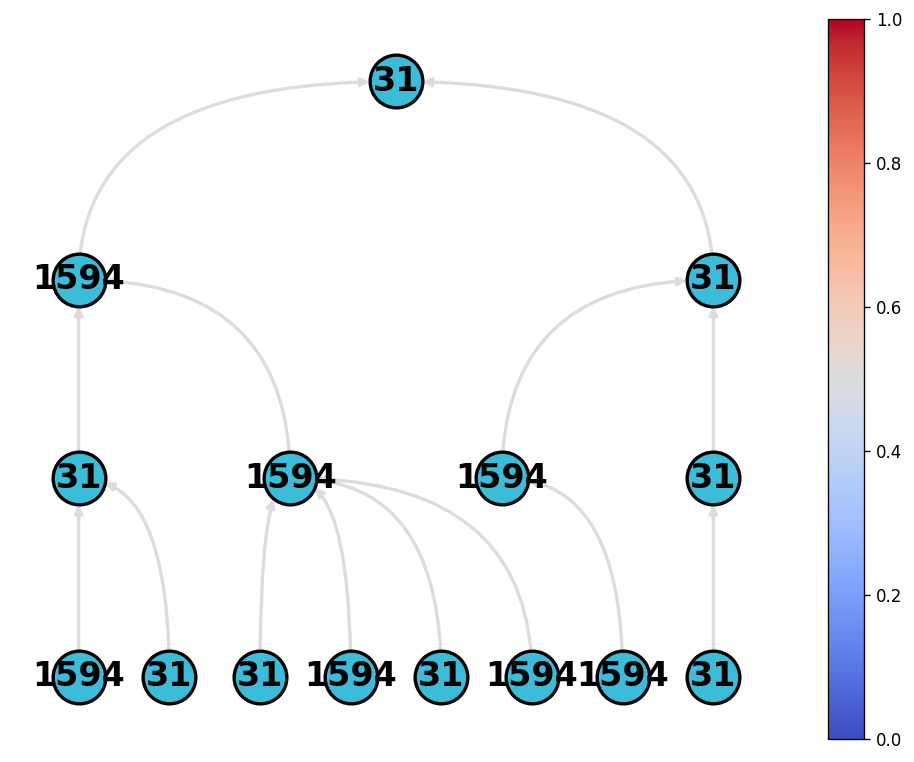

In [7]:
# Label information: 0 = base nodes / 1 = Middle / 2 = Bottom / 3 = Top
# Visualizing k-hop subgraph from a target node

# 433, 482
target_idx = 31
num_hops = 3

subset_orig, edge_index_orig, inv_orig, _ = k_hop_subgraph(node_idx=target_idx,
                                                                        num_hops=num_hops,
                                                                        edge_index=data.edge_index,
                                                                        relabel_nodes=False)

subset, edge_index, inv, _, _ = k_hop_subgraph_modified(node_idx=target_idx, 
                                                        num_hops=num_hops, 
                                                        edge_index=data.edge_index)

subgraph_data_orig = Data(x=data.x[subset_orig], 
                        edge_index=edge_index_orig,
                        y=data.y[subset_orig])
subgraph_data = Data(x=data.x[subset], 
                    edge_index=edge_index,
                    y=data.y[subset])

# Make a graph from the edge list (of tuples)
G_orig = nx.from_edgelist(edge_index_orig.t().tolist())
G = nx.from_edgelist(edge_index.t().tolist())


# num_layers = get_num_hops(model)
num_layers = 3

att_dict_raw = get_attention_raw_dict_multihead(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph_deprecated(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
    with_labels=True
)

In [8]:
comp_graph

{0: tensor([[1594,   31],
         [  31,   31]]),
 1: tensor([[  31, 1594, 1594,   31],
         [1594, 1594,   31,   31]]),
 2: tensor([[1594,   31,   31, 1594,   31, 1594, 1594,   31],
         [  31,   31, 1594, 1594, 1594, 1594,   31,   31]])}

In [9]:
nodes_per_level_new

[tensor([0]),
 tensor([1, 2]),
 tensor([3, 4, 5, 6]),
 tensor([ 7,  8,  9, 10, 11, 12, 13, 14])]

In [10]:
nodes_per_level_original

[tensor([31]),
 tensor([1594,   31]),
 tensor([  31, 1594, 1594,   31]),
 tensor([1594,   31,   31, 1594,   31, 1594, 1594,   31])]

In [11]:
comp_graph_new

{0: tensor([[1, 2],
         [0, 0]]),
 1: tensor([[3, 4, 5, 6],
         [1, 1, 2, 2]]),
 2: tensor([[ 7,  8,  9, 10, 11, 12, 13, 14],
         [ 3,  3,  4,  4,  4,  4,  5,  6]])}

In [13]:
# Label information: 0 = base nodes / 1 = Middle / 2 = Bottom / 3 = Top
# Visualizing k-hop subgraph from a target node
from torch_geometric.utils import degree

degree_out = degree(data.edge_index[1])
# 433, 482
target_idx = 31
num_hops = 3

subset_orig, edge_index_orig, inv_orig, _ = k_hop_subgraph(node_idx=target_idx,
                                                                        num_hops=num_hops,
                                                                        edge_index=data.edge_index,
                                                                        relabel_nodes=False)

subset, edge_index, inv, _, _ = k_hop_subgraph_modified(node_idx=target_idx, 
                                                        num_hops=num_hops, 
                                                        edge_index=data.edge_index)

subgraph_data_orig = Data(x=data.x[subset_orig], 
                        edge_index=edge_index_orig,
                        y=data.y[subset_orig])
subgraph_data = Data(x=data.x[subset], 
                    edge_index=edge_index,
                    y=data.y[subset])

# Make a graph from the edge list (of tuples)
G_orig = nx.from_edgelist(edge_index_orig.t().tolist())
G = nx.from_edgelist(edge_index.t().tolist())


# num_layers = get_num_hops(model)
num_layers = 3

att_dict_raw = get_attention_raw_dict_multihead(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)

degree = dict(G.degree)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
    degree=degree_out
)

layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
    with_labels=True
)

IndexError: index 1 is out of bounds for dimension 0 with size 1